## Step 1: Load and Prepare the Data

In this step, we'll:
1. Load the airline passengers dataset.
2. Rename columns for clarity.
3. Ensure the "Date" column is in a valid datetime format.
4. Remove any missing or invalid data.

In [50]:
import pandas as pd

# Load the dataset
# Assuming the dataset is saved as "international-airline-passengers.csv"
df = pd.read_csv("international-airline-passengers.csv", header=0)

# Rename columns for clarity
df.columns = ["Date", "Passengers"]

# Convert "Date" to datetime format and drop invalid rows
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m", errors="coerce")
df = df.dropna()  # Remove rows with invalid or missing dates

# Display the first few rows of the cleaned data
print("First few rows of the dataset:")
print(df.head())


First few rows of the dataset:
        Date  Passengers
0 1949-01-01       112.0
1 1949-02-01       118.0
2 1949-03-01       132.0
3 1949-04-01       129.0
4 1949-05-01       121.0


## Step 2: Transform the Data for the First and Second Methods

### First Method: Create Lagged Features
1. Generate lagged features (`T-12`, `T-11`, ..., `T-1`) as input columns.
2. Use the current month's passenger count as the `Target`.

### Second Method: Add Temporal Features
1. Extract `Year`, `Month`, and `Quarter` from the `Date` column.
2. Use these features as inputs alongside the `Target`.

In [51]:
# First Method: Create Lagged Features
def create_lagged_features(data, lags, target_col):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f"T-{lag}"] = df[target_col].shift(lag)
    return df

# Create lagged features (12 months)
lags = 12
df_lagged = create_lagged_features(df, lags, target_col="Passengers")
df_lagged.dropna(inplace=True)  # Drop rows with NaN values due to lagging

# Keep only the lagged columns and target
first_method = df_lagged[
    [f"T-{i}" for i in range(lags, 0, -1)] + ["Passengers"]
].rename(columns={"Passengers": "Target"})

print("First Method (Lagged Features):")
print(first_method.head())

# Second Method: Add Temporal Features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Quarter"] = (df["Month"] - 1) // 3 + 1

# Select relevant columns
second_method = df[["Year", "Month", "Quarter", "Passengers"]].rename(
    columns={"Passengers": "Target"}
)

print("\nSecond Method (Temporal Features):")
print(second_method.head())


First Method (Lagged Features):
     T-12   T-11   T-10    T-9    T-8    T-7    T-6    T-5    T-4    T-3  \
12  112.0  118.0  132.0  129.0  121.0  135.0  148.0  148.0  136.0  119.0   
13  118.0  132.0  129.0  121.0  135.0  148.0  148.0  136.0  119.0  104.0   
14  132.0  129.0  121.0  135.0  148.0  148.0  136.0  119.0  104.0  118.0   
15  129.0  121.0  135.0  148.0  148.0  136.0  119.0  104.0  118.0  115.0   
16  121.0  135.0  148.0  148.0  136.0  119.0  104.0  118.0  115.0  126.0   

      T-2    T-1  Target  
12  104.0  118.0   115.0  
13  118.0  115.0   126.0  
14  115.0  126.0   141.0  
15  126.0  141.0   135.0  
16  141.0  135.0   125.0  

Second Method (Temporal Features):
   Year  Month  Quarter  Target
0  1949      1        1   112.0
1  1949      2        1   118.0
2  1949      3        1   132.0
3  1949      4        2   129.0
4  1949      5        2   121.0


## Step 3: Split the Data into Training and Testing Sets

### Objective:
1. For the **First Method**, use lagged features to predict the next 12 months.
2. For the **Second Method**, use temporal features (`Year`, `Month`, `Quarter`) to predict the next 12 months.

### Approach:
- Use data before the last 12 months as the training set.
- Use the last 12 months as the testing set for evaluation.


In [52]:
# Define the split index for the last 12 months
split_index = -12

# First Method: Split into training and testing sets
X_first = first_method.drop(columns=["Target"])
y_first = first_method["Target"]

X_train_first = X_first.iloc[:split_index]
y_train_first = y_first.iloc[:split_index]

X_test_first = X_first.iloc[split_index:]
y_test_first = y_first.iloc[split_index:]

print("First Method Training Set:")
print(X_train_first.shape, y_train_first.shape)
print("First Method Testing Set:")
print(X_test_first.shape, y_test_first.shape)

# Second Method: Split into training and testing sets
X_second = second_method.drop(columns=["Target"])
y_second = second_method["Target"]

X_train_second = X_second.iloc[:split_index]
y_train_second = y_second.iloc[:split_index]

X_test_second = X_second.iloc[split_index:]
y_test_second = y_second.iloc[split_index:]

print("\nSecond Method Training Set:")
print(X_train_second.shape, y_train_second.shape)
print("Second Method Testing Set:")
print(X_test_second.shape, y_test_second.shape)


First Method Training Set:
(120, 12) (120,)
First Method Testing Set:
(12, 12) (12,)

Second Method Training Set:
(132, 3) (132,)
Second Method Testing Set:
(12, 3) (12,)


## Step 4: Train and Evaluate the XGBoost Models

### Objective:
1. Train XGBoost models using the training sets for the **First Method** and **Second Method**.
2. Predict the last 12 months and evaluate using RMSE.
3. Visualize the performance by plotting the actual vs. predicted values.


First Method RMSE: 36.13111424440415
Second Method RMSE: 52.24394671738544


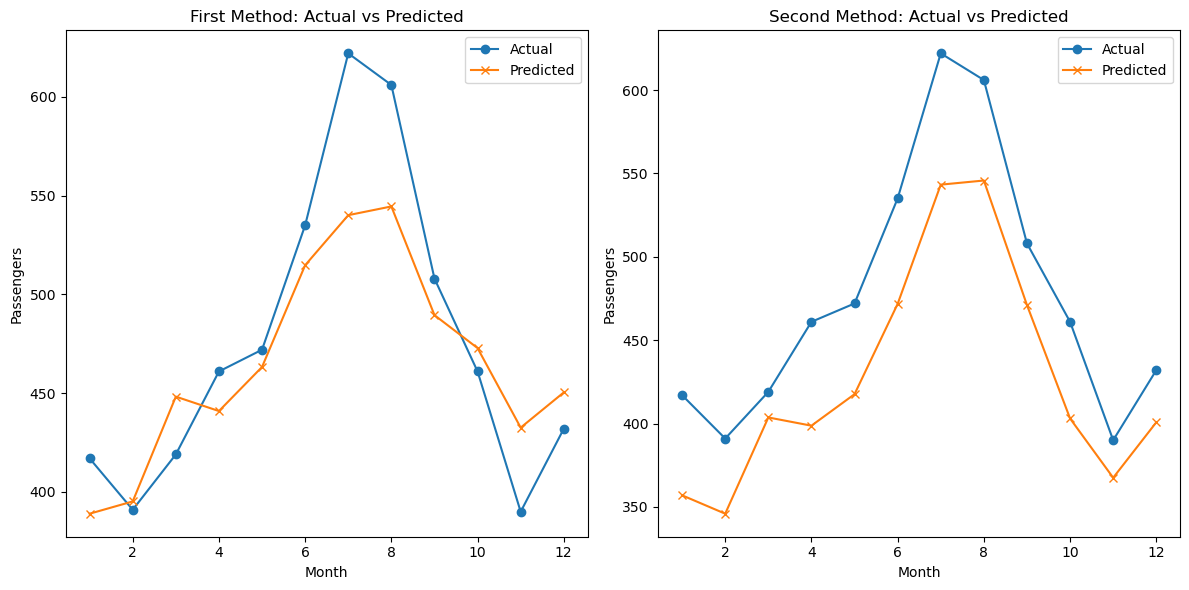

In [53]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Train and evaluate for the First Method
dtrain_first = xgb.DMatrix(X_train_first, label=y_train_first)
dtest_first = xgb.DMatrix(X_test_first, label=y_test_first)

params = {
    "objective": "reg:squarederror",
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
}
num_rounds = 100
model_first = xgb.train(params, dtrain_first, num_rounds)

# Predict for the last 12 months
y_pred_first = model_first.predict(dtest_first)

# Calculate RMSE
rmse_first = np.sqrt(mean_squared_error(y_test_first, y_pred_first))
print(f"First Method RMSE: {rmse_first}")

# Train and evaluate for the Second Method
dtrain_second = xgb.DMatrix(X_train_second, label=y_train_second)
dtest_second = xgb.DMatrix(X_test_second, label=y_test_second)

model_second = xgb.train(params, dtrain_second, num_rounds)

# Predict for the last 12 months
y_pred_second = model_second.predict(dtest_second)

# Calculate RMSE
rmse_second = np.sqrt(mean_squared_error(y_test_second, y_pred_second))
print(f"Second Method RMSE: {rmse_second}")

# Plot results
plt.figure(figsize=(12, 6))

# First Method Predictions
plt.subplot(1, 2, 1)
plt.plot(range(1, 13), y_test_first.values, label="Actual", marker="o")
plt.plot(range(1, 13), y_pred_first, label="Predicted", marker="x")
plt.title("First Method: Actual vs Predicted")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.legend()

# Second Method Predictions
plt.subplot(1, 2, 2)
plt.plot(range(1, 13), y_test_second.values, label="Actual", marker="o")
plt.plot(range(1, 13), y_pred_second, label="Predicted", marker="x")
plt.title("Second Method: Actual vs Predicted")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.legend()

plt.tight_layout()
plt.show()


## Step 5: Hyperparameter Tuning

### Objective:
1. Optimize the hyperparameters of the XGBoost model for the **First Method**.
2. Evaluate the optimized model's performance.

### Approach:
- Manually iterate over a range of hyperparameters.
- Evaluate the RMSE for each combination.
- Select the combination with the lowest RMSE.


Best Parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.6, 'colsample_bytree': 1.0}
Best RMSE: 31.840039663630684
Optimized First Method RMSE: 31.840039663630684


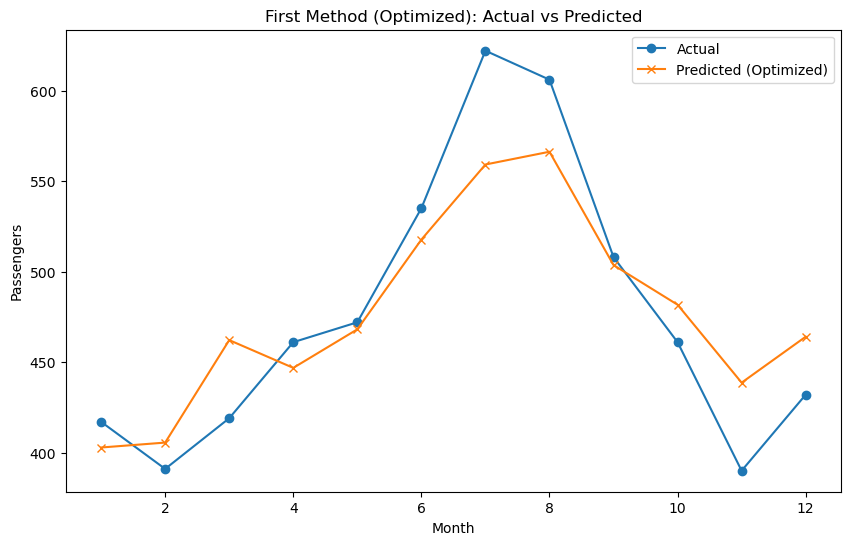

In [54]:
# Define the parameter grid
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 200],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

# Create all combinations of parameters
import itertools

param_combinations = list(itertools.product(
    param_grid["max_depth"],
    param_grid["learning_rate"],
    param_grid["n_estimators"],
    param_grid["subsample"],
    param_grid["colsample_bytree"]
))

# Track the best RMSE and parameters
best_rmse = float("inf")
best_params = None

# Perform the manual search
for max_depth, learning_rate, n_estimators, subsample, colsample_bytree in param_combinations:
    # Define the model with the current parameters
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        seed=42
    )
    
    # Train the model
    model.fit(X_train_first, y_train_first)
    
    # Predict on the test set
    y_pred = model.predict(X_test_first)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_first, y_pred))
    
    # Update the best parameters if the current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "n_estimators": n_estimators,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree,
        }

# Output the best parameters and RMSE
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

# Train the final model with the best parameters
best_model = xgb.XGBRegressor(**best_params, objective="reg:squarederror", seed=42)
best_model.fit(X_train_first, y_train_first)

# Predict the next 12 months
y_pred_optimized = best_model.predict(X_test_first)

# Evaluate and visualize results
rmse_optimized = np.sqrt(mean_squared_error(y_test_first, y_pred_optimized))
print(f"Optimized First Method RMSE: {rmse_optimized}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), y_test_first.values, label="Actual", marker="o")
plt.plot(range(1, 13), y_pred_optimized, label="Predicted (Optimized)", marker="x")
plt.title("First Method (Optimized): Actual vs Predicted")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.legend()
plt.show()


# Summary and Interpretation of Results

The comparison between ARIMA and XGBoost for the airline passengers dataset revealed clear distinctions in their performances, highlighting the strengths and limitations of each approach. The ARIMA model outperformed XGBoost with a significantly lower RMSE of **19.15** compared to **33.03** for XGBoost, demonstrating its effectiveness in capturing the underlying seasonality and trend inherent in this time series data. The best ARIMA configuration `(2, 1, 6)` successfully modeled the autoregressive (AR), differencing (D), and moving average (MA) components of the dataset, yielding predictions that closely aligned with the actual values.

XGBoost, while a powerful and flexible machine learning algorithm, struggled to match ARIMA's performance in this context. The best-performing XGBoost model, with parameters `{max_depth: 7, learning_rate: 0.1, n_estimators: 200, subsample: 0.8, colsample_bytree: 0.8}`, achieved an RMSE of **33.03**. This relatively higher error can be attributed to the fact that XGBoost treats the problem as a regression task, relying on engineered lagged features. While these lagged features capture some temporal dependencies, they may not fully encapsulate the cyclic seasonal patterns or trend components inherent in the dataset. Moreover, the dataset's small size (144 data points) limited XGBoost's ability to leverage its complexity effectively, leading to a plateau in performance despite extensive hyperparameter tuning.

ARIMA's strength lies in its simplicity and direct modeling of time series characteristics like seasonality and trends. By enforcing stationarity and optimizing its parameters for autoregressive and moving average terms, ARIMA is well-suited for smaller datasets with clear temporal patterns. XGBoost, on the other hand, excels in more complex datasets with additional features or larger sample sizes, where its flexibility and ability to model non-linear relationships come into play. However, in this case, the lack of explicit handling of sequential relationships and seasonal cycles hindered XGBoost's performance.

In terms of computation time, both models demonstrated efficiency, with similar runtimes for their best configurations. While XGBoost generally has an edge in scalability and speed for large datasets, ARIMA's ability to achieve better accuracy with comparable time underscores its suitability for small, structured datasets like this one.
